<a href="https://colab.research.google.com/github/carlapvalera/LLM-ML/blob/main/source/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForQuestionAnswering, BertTokenizerFast, AdamW
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import os
from google.colab import drive

# 1. Cargar el dataset SQuAD
print("Cargando el dataset...")
dataset = load_dataset("squad")

# Recortar el dataset para pruebas rápidas
#train_size = 100  # Número de ejemplos de entrenamiento
#eval_size = 20   # Número de ejemplos de evaluación

#dataset["train"] = dataset["train"].select(range(train_size))
#dataset["validation"] = dataset["validation"].select(range(eval_size))

# 2. Cargar el modelo BERT y el tokenizador
print("Cargando el modelo BERT y el tokenizador...")
model_name = "bert-base-uncased"
model = BertForQuestionAnswering.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# 3. Preprocesar los datos
print("Preprocesando los datos...")
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

# 4. Preparar los dataloaders
print("Preparando los dataloaders...")
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

# Convertir los datasets a TensorDatasets
def convert_to_tensordataset(dataset):
    print("Convertir los datasets a TensorDatasets")
    return TensorDataset(
        torch.tensor(dataset['input_ids']),
        torch.tensor(dataset['attention_mask']),
        torch.tensor(dataset['start_positions']),
        torch.tensor(dataset['end_positions'])
    )

train_dataset = convert_to_tensordataset(train_dataset)
eval_dataset = convert_to_tensordataset(eval_dataset)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

# 5. Configurar el entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

# 6. Función de entrenamiento
def process_batch(batch, device):
    if isinstance(batch, list):
        # Si es una lista, asumimos que los elementos están en este orden
        input_ids, attention_mask, start_positions, end_positions = batch
        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'start_positions': start_positions.to(device),
            'end_positions': end_positions.to(device)
        }
    elif isinstance(batch, dict):
        return {k: v.to(device) for k, v in batch.items()}
    else:
        raise ValueError(f"Unexpected batch type: {type(batch)}")

def train(model, dataloader, optimizer, device):
    model.train()
    for batch in tqdm(dataloader, desc="Entrenando"):
        batch = process_batch(batch, device)
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# 7. Función de evaluación
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando"):
            batch = process_batch(batch, device)
            outputs = model(**batch)
            total_loss += outputs.loss.item()

            # Obtener predicciones
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits
            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)

            # Aplanar las predicciones y las etiquetas
            predictions = torch.stack((start_pred, end_pred), dim=1).view(-1).cpu().numpy()
            labels = torch.stack((batch['start_positions'], batch['end_positions']), dim=1).view(-1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return total_loss / len(dataloader), accuracy, f1

# ... (El resto del código permanece igual hasta la sección de entrenamiento y evaluación)


# 8. Entrenamiento y evaluación
num_epochs = 1
print(f"Comenzando entrenamiento por {num_epochs} épocas...")

# Montar Google Drive
drive.mount('/content/drive')

# Crear un directorio en Google Drive para guardar los checkpoints
save_dir = "/content/drive/MyDrive/fine_tuned_bert_squad"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

checkpoint_path = os.path.join(save_dir, "checkpoint.pt")

for epoch in range(num_epochs):
    print(f"Época {epoch + 1}/{num_epochs}")

    # Cargar los pesos de la época anterior si existen
    if epoch > -1 and os.path.exists(checkpoint_path):
        print(f"Cargando pesos de la época anterior")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    train(model, train_dataloader, optimizer, device)
    loss, accuracy, f1 = evaluate(model, eval_dataloader, device)
    print(f"Pérdida de validación: {loss:.4f}")
    print(f"Exactitud de validación: {accuracy:.2%}")
    print(f"F1-score de validación: {f1:.4f}")

    # Guardar los pesos del modelo al final de cada época
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'f1': f1,
    }, checkpoint_path)
    print(f"Checkpoint guardado en {checkpoint_path}")

# Guardar el modelo final en Google Drive
print("Guardando el modelo final...")
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("¡Entrenamiento completado!")

Cargando el dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Cargando el modelo BERT y el tokenizador...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Preprocesando los datos...


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [3]:
from flask import Flask, request, jsonify
import torch
from transformers import BertForQuestionAnswering, BertTokenizerFast
from google.colab import drive

app = Flask(__name__)

# Montar Google Drive
drive.mount('/content/drive', force_remount=True)

# Cargar el modelo y el tokenizador
model_path = "/content/drive/MyDrive/fine_tuned_bert_squad"  # Ruta donde guardaste tu modelo entrenado
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def answer_question(question, context):
    # Tokenizar la pregunta y el contexto
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Obtener predicciones
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Obtener las posiciones de inicio y fin de la respuesta
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits)

    # Convertir las posiciones de los tokens a las posiciones de los caracteres en el contexto
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    answer = tokenizer.convert_tokens_to_string(tokens[answer_start:answer_end+1])

    # Limpiar la respuesta
    answer = answer.replace("[CLS]", "").replace("[SEP]", "").strip()

    return answer

question = "como se llama mi amiguito"
context = "leo es una persomna,Este ejemplo muestra cómo crear una API simple usando Flask para utilizar tu modelo BERT entrenado para responder preguntas. La API acepta solicitudes POST con una pregunta y un contexto, y devuelve la respuesta generada por el modelo. Puedes extender esta API para incluir más funcionalidades según tus necesidades,leo es mi amigo"
answer =answer_question(question, context)
print(answer)

if __name__ == '__main__':
    question = "como se llama mi amiguito"
    context = "leo es una persomna,Este ejemplo muestra cómo crear una API simple usando Flask para utilizar tu modelo BERT entrenado para responder preguntas. La API acepta solicitudes POST con una pregunta y un contexto, y devuelve la respuesta generada por el modelo. Puedes extender esta API para incluir más funcionalidades según tus necesidades,leo es mi amigo"
    print(answer_question(question, context))


Mounted at /content/drive
leo es una persomna, este ejemplo muestra como crear una api simple usando flask para utilizar tu modelo bert entrenado para responder preguntas. la api
leo es una persomna, este ejemplo muestra como crear una api simple usando flask para utilizar tu modelo bert entrenado para responder preguntas. la api


In [4]:
!pip install -U spacy
!python -m spacy download es_core_news_sm
!pip install neo4j
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 26.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Cargar el modelo y el tokenizador
model_name = "t5-small"  # Puedes usar "t5-base" o "t5-large" para mejores resultados, pero requieren más recursos
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def summarize_text(text, max_length=100):
    # Preparar el input
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)

    # Generar el resumen
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decodificar y retornar el resumen
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Ejemplo de uso
text = "Este es un texto de ejemplo que se utilizará para generar un resumen usando el modelo T5. El resumen debe capturar las ideas principales del texto de manera concisa y clara."
summary = summarize_text(text)
print("Texto original:")
print(text)
print("\nResumen:")
print(summary)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Texto original:
Este es un texto de ejemplo que se utilizará para generar un resumen usando el modelo T5. El resumen debe capturar las ideas principales del texto de manera concisa y clara.

Resumen:
es un texto de ejemplo que se utilizará para generar un resumen usando el modelo T5.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import threading

def get_similarity(query:str,vector_space:list, k:int) -> list[tuple[str,float]]: #TODO
    """
    Finds the k most relevant texts in a set of texts given a query text.

    Parameters:
        - query (str): The query text.
        - vector_space (list): A list of texts to search.
        - k (int): The number of most relevant texts to return.

    Returns:
        A list of tuples (text, score) where text is one of the k most
        relevant texts and score is its degree of similarity to the query text.
    """
    if vector_space==[]:
        return []
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Ajustar y transformar el texto de consulta y el conjunto de textos
    X = vectorizer.fit_transform([query] + vector_space)

    # Calcular la similitud de coseno entre el texto de consulta y cada texto en el conjunto
    similarities = cosine_similarity(X[0], X[1:])

    # Ordenar los textos por similitud de coseno en orden descendente
    sorted_indices = similarities.argsort()[0][::-1]

    # Devolver los k textos más relevantes
    return [(vector_space[i], similarities[0][i]) for i in sorted_indices[:k]]


class LTM_Node:
    '''
        A node in the LTM network.
        There is two kind of nodes:
            -The actual past conversations:
                These kind of nodes cannot have any children
            -The summary nodes:
                This kind has any number of children in a dictionary (vector->node)
                His vector is just a summary of his children vectors
    '''

    def __init__(self, arg:str|list['LTM_Node'],is_leaf=True):

        if is_leaf:
            '''
                This represent a new memory in LTM
                conversation: the conversation that this node represents
                parents: a list of the nodes that are parents of this node
            '''
            self.vector:str = arg
            self.children: dict[str,'LTM_Node']|None = None
            self.is_leaf:bool = True
            self.parents:list['LTM_Node'] = []
            return

        '''
            This represent a summary of memories
            MemoryList: a list of the memories that this node summarizes (children nodes)
            parents: a list of the nodes that are parents of this node
        '''
        self.children: dict[str,'LTM_Node']|None = {x.vector:x for x in arg}
        self.vector:str = self.calculate_vector()
        self.is_leaf:bool=False
        self.parents=[]

    def insert(self,node:'LTM_Node'):
        '''
            Adds a new children. This node(self) cannot be a memory node
        '''
        if self.children==None:
            raise Exception("LTM Insertion Error")
        else:
            self.children[node.vector]=node
            node.parents.append(self)
        self.update()

    def mix_memories(self, vector:str, new_memory_node:'LTM_Node'):
        '''
            Mix a new memory with a child in a new summary node,
            The new summary will be son of this node instead of the mixed child
            - vector: the vector of the child that will be mixed
            - new_memory_node: the new memory node
        '''
        old_child = self.children[vector]
        new_summary=LTM_Node([old_child,new_memory_node], False)
        new_memory_node.parents.append(new_summary)
        old_child.parents.remove(self)
        old_child.parents.append(new_summary)
        self.children.pop(vector)
        self.insert(new_summary)

    def update(self):
        '''
            Update the vector of this node and the parents of this node
        '''
        if self.children==None:
            return
        self.children={x.vector:x for _, x in self.children.items()}
        self.vector=self.calculate_vector()
        for p in self.parents:
            p.update()

    def get_space(self) -> list[str]|None:
        '''
            Return all the children vectors
        '''
        if self.is_leaf:
            return None
        return list(self.children.keys())

    def calculate_vector(self) -> str:
        """
        Calculate a summary of this node's children using the summarize_text method
        """
        if not self.children:
            return "No hay información para resumir."

        # Combine all texts from children
        combined_text = " ".join([node.vector for node in self.children.values()])
        # Use the summarize_text method to generate a summary of the combined texts
        summary = summarize_text(combined_text, max_length=150)

        return summary

class LTM:
    '''
        This class represents the LTM of the model.
        Contains a LTM_Node graph starting with the root node.
        This structure has 2 hyper-parameters:
            - _lambda: the minimum level of relevance that a vector must have for a query
            - k_child: the number of vectors retrieved to a query
        The hyper parameter 'k_child' will also be relevant for the graph construction:
            - For k=1: The graph will be a tree
            - For k>1: The graph will be a DAG
    '''

    def __init__(self, _lambda:float=0.5, k_child:int=1):
        self.root=LTM_Node([], False)
        self._lambda=_lambda
        self.k_child=k_child
        self.where_to_insert=[]
        #NOTE: THE VARIABLE 'where_to_insert' IS USED TO STORAGE A NEW MEMORY,
        # BASED ON THE SEARCH RESULTS HAS THE STRUCTURE [(node,vector)], WHERE:
        #       - node will be the father of the new memory
        #       - vector will be the most relevant vector

    def insert(self,new_memory:str):
        '''
            Insert a new memory in the LTM.

            It will be inserted on the nodes that were relevant for the prompt
            stored in 'where_to_insert' variable updated in 'get_vector' method.
        '''
        new_node = LTM_Node(new_memory)

        for node, vector in self.where_to_insert:
            if node.vector==vector and not vector in node.children.keys():
                #NOTE: Situation 1: The most relevant node was a summary.
                node.insert(new_node)
            else:
                #NOTE: Situation 2: The most relevant node was another memory.
                node.mix_memories(vector,new_node)

        self.where_to_insert=[]

    def get_vector(self, prompt:str) -> list[str]:
        '''
            Return the first k (from 'k_child' variable) most relevant vectors for the prompt

            Also, save the nodes that will be the parents of the new memory and the relevant vectors
            for new memory insertion.
        '''

        self.where_to_insert = [
            (node, vector) for node, vector, _ in
            self.relevant_nodes(self.root, prompt,self._lambda)
        ]

        if len(self.where_to_insert)==0:
            #NOTE: CASE OF NO RELEVANT MEMORIES
            self.where_to_insert=[(self.root,self.root.vector)]
            return ['']

        return [vector for _,vector in self.where_to_insert]

    def relevant_nodes(self, node:LTM_Node, prompt:str,
        _lambda:float, solution=None) -> list[tuple[LTM_Node,str,float]]:
        '''
            Receives a LTM, a prompt and a lambda value
            Return a list of tuple (node, vector, similarity) where:
            - node is the node that gives the future parent vector of the memory
            - vector is the vector that was relevant for the prompt (greater than lambda)
            - similarity is the similarity between the vector and the prompt
            The tuple is also stored in solution
        '''
        if solution==None:
            solution=[]

        best_results = get_similarity(prompt, node.get_space(), self.k_child)

        #The following 3 list are made for a summary node. The i-est element represents each child
        child_node=[]
        child_threads=[]
        child_relevant_nodes=[]

        for vector, similarity in best_results:

            if node.children[vector].is_leaf:
                # On this case the future parent of the memory cannot be the vector itself.
                # So, we will return the parent of the vector and the memories will
                # be mixed into a new summary that will be storage in the parent.
                if similarity>_lambda:
                    solution.append((node,vector, similarity))
                continue

            # If the relevant vector is a summary, we return the best result between this vector and
            # the recursive call on this vector. This process will be running on a thread
            child_node.append((node.children[vector],vector,similarity))
            child_relevant_nodes.append([])
            child_threads.append(threading.Thread(target=self.relevant_nodes,
                args=(node.children[vector], prompt,max(_lambda,similarity), child_relevant_nodes[-1])))
            child_threads[-1].start()

        #Joining the threads
        for i in range(len(child_threads)):
            child_threads[i].join()
            _,_,similarity = child_node[i]
            if len(child_relevant_nodes[i])!=0:
                solution.append(child_relevant_nodes[i][0])
            elif similarity > _lambda:
                solution.append(child_node[i])

        solution.sort(key = lambda x:x[2], reverse=True)
        return solution

In [7]:
from collections import defaultdict
import time

class ShortTermMemory:
    def __init__(self, max_size=100, update_frequency=10, auto_delete_frequency=20):
        self.max_size = max_size
        self.update_frequency = update_frequency
        self.auto_delete_frequency = auto_delete_frequency
        self.memory = defaultdict(lambda: [0, time.time()])

    def clear(self):
        self.memory=defaultdict(lambda: [0, time.time()])

    def add(self, item):
        if item in self.memory:
            self.memory[item][0] += 1
            if self.memory[item][0] % self.auto_delete_frequency == 0:
                del self.memory[item]
        else:
            self.memory[item] = [1, time.time()]
            self._prune_memory()

    def _prune_memory(self):
        if len(self.memory) > self.max_size:
            oldest_items = sorted(self.memory.items(), key=lambda x: x[1][1])
            for item, (count, timestamp) in oldest_items[:-self.max_size]:
                del self.memory[item]

    def update(self):
        current_time = time.time()
        for item, (count, timestamp) in list(self.memory.items()):
            if count % self.update_frequency == 0:
                self.memory[item][1] = current_time
            self.memory[item][0] += 1
            if self.memory[item][0] % self.auto_delete_frequency == 0:
                del self.memory[item]
        self._prune_memory()

# Ejemplo de uso
short_term_memory = ShortTermMemory(max_size=50, update_frequency=5, auto_delete_frequency=10)

short_term_memory.add("apple")
short_term_memory.add("banana")
short_term_memory.add("cherry")
short_term_memory.add("apple")
short_term_memory.add("banana")

print(short_term_memory.memory)
# Output: defaultdict(<function ShortTermMemory.<lambda>.<locals>.<lambda> at 0x7f6a8c0c8d60>, {'apple': [2, 1619540400.0], 'banana': [2, 1619540400.0], 'cherry': [1, 1619540400.0]})

short_term_memory.update()
print(short_term_memory.memory)
# Output: defaultdict(<function ShortTermMemory.<lambda>.<locals>.<lambda> at 0x7f6a8c0c8d60>, {'apple': [3, 1619540405.0], 'banana': [3, 1619540405.0]})

defaultdict(<function ShortTermMemory.__init__.<locals>.<lambda> at 0x7f331e583ac0>, {'apple': [2, 1720610131.2595387], 'banana': [2, 1720610131.259583], 'cherry': [1, 1720610131.259623]})
defaultdict(<function ShortTermMemory.__init__.<locals>.<lambda> at 0x7f331e583ac0>, {'apple': [3, 1720610131.2595387], 'banana': [3, 1720610131.259583], 'cherry': [2, 1720610131.259623]})


In [8]:
# Creación de una instancia de LTM
ltm = LTM(_lambda=0.01, k_child=1)

In [9]:
# Función para obtener memoria relevante
def get_relevant_short_term_memory(prompt: str):
    answer = []
    for k, v in short_term_memory.memory:
        answer.append(answer_question(prompt, k))
    return answer

def concatenate_strings(string_list, user_input):
    """
    Concatena una lista de strings.

    Parámetros:
    - string_list (list): La lista de strings a concatenar.
    - user_input (str): La entrada del usuario a añadir al final.

    Devuelve:
    - str: El resultado de concatenar todos los strings en la lista y la entrada del usuario.
    """
    result = ""
    for string in string_list:
        result += string
    result += user_input
    return result
def update_short_term_memory(user_input, response, short_term_memory):
    # Añadir la entrada del usuario a la memoria a corto plazo
    short_term_memory.add(user_input)

    # Añadir la respuesta del LLM a la memoria a corto plazo
    short_term_memory.add(response)

    # Actualizar la memoria a corto plazo
    short_term_memory.update()

In [10]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [12]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

class LLM:
    def __init__(self):
        self.model_name = "gpt2"
        self.tokenizer = GPT2Tokenizer.from_pretrained(self.model_name)
        self.model = GPT2LMHeadModel.from_pretrained(self.model_name)

    def generate_response(self, prompt, max_length=500):
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        attention_mask = torch.ones(inputs.shape, dtype=torch.long)
        outputs = self.model.generate(inputs,
                                      max_length=max_length,
                                      num_return_sequences=1,
                                      attention_mask=attention_mask,
                                      no_repeat_ngram_size=2,
                                      temperature=0.7)
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response

def create_prompt(user_input, relevant_short_term_memory, relevant_long_term_memory):
    K_shot='''
    Contexto: En Francia, sus ciudades son Lyon y su capital Paris\n
    Pregunta: Cual es la capital de Francia\n
    Respuesta: Paris\n\n

    Contexto: Los mejores pintores del renacimiento fueron muchos\n
    Pregunta: Quien pinto la mona lisa\n
    Respuesta: Leonardo Da Vinci\n\n

    '''

    context = f"Contexto: {relevant_short_term_memory}\n"
    context += f"{relevant_long_term_memory}\n"
    prompt = f"{context}\nPregunta: {user_input}\nRespuesta: "
    return prompt

def get_relevant_short_term_memory(user_input, short_term_memory):
    # Aquí iría tu lógica para obtener la memoria a corto plazo relevante
    answer = []
    for k, v in short_term_memory.memory:
        answer.append(k)
    return '. '.join(answer)


# Inicializar el modelo
#llm = LLM()

# Uso
#user_input = input("Ingresa tu pregunta: ")

# Obtener las memorias relevantes
#relevant_short_term_memory = get_relevant_short_term_memory(user_input)
##relevant_long_term_memory = get_relevant_long_term_memory(user_input)

# Crear el prompt y generar la respuesta
#prompt = create_prompt(user_input, relevant_short_term_memory, relevant_long_term_memory)
##response = llm.generate_response(prompt)

#print("Respuesta generada:")
#print(response)

In [13]:
# 1. Inicializar el modelo
llm = LLM()
short_term_memory = ShortTermMemory(max_size=3, update_frequency=3, auto_delete_frequency=3)
short_term_memory.clear()
long_term_memory = LTM(_lambda=0.01, k_child=1)

print(short_term_memory.memory)
a=100

while True:
    # 2. Obtener la entrada del usuario
    user_input = input("Ingresa tu pregunta: ")

    if user_input=='~~~':
        break

    # 3. Obtener el contexto relevante
    try:
        relevant_short_term_memory = get_relevant_short_term_memory(user_input,short_term_memory)
    except Exception as e:
        print("Error al obtener el contexto:", str(e))
    # 3. Extraer lo más relevante de la memoria a largo plazo

    relevant_long_term_memory='. '.join(long_term_memory.get_vector(context+' '+user_input))

    # 4. Usar todo lo extraído como contexto para generar una respuesta con el LLM

    prompt = create_prompt(user_input, relevant_short_term_memory, relevant_long_term_memory)

    response = llm.generate_response(prompt,1000)
    a+=150

    # 5. Actualizar la memoria a corto plazo con la respuesta del LLM
    update_short_term_memory(user_input, response, short_term_memory)
    # 6. Insertar la respuesta en la memoria a largo plazo
    long_term_memory.insert(response)

    print(response)

defaultdict(<function ShortTermMemory.clear.<locals>.<lambda> at 0x7f331cbd0b80>, {})
Ingresa tu pregunta: hola


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Contexto: 


Pregunta: hola
Respuesta: 

Ceres:
.




Presto de la Punta de Piedras:

.

 (1)

,

: (2)
,
:,
 (3),

-

 and

(4) :

.




KeyboardInterrupt: Interrupted by user

In [14]:
ltm=LTM(0.01,1)
while True:
    user_input = input("Ingresa tu pregunta: ")
    if user_input=='~~~':
        break
    ltm.get_vector(user_input)
    ltm.insert(user_input)

queque=[ltm.root]
while queque!=[]:
  a=queque[0]
  queque.remove(a)
  print(a.vector)
  print(a.get_space())
  print(a.parents.vector)
  if a.is_leaf:
    continue
  for x in a.children:
    queque.append(a.children[x])

Ingresa tu pregunta: hola
Ingresa tu pregunta: hola


KeyboardInterrupt: 

In [ ]:
queque=[ltm.root]
dic=dict()
c=0
while queque!=[]:
  a=queque[0]
  dic[a.vector]=c
  c+=1
  queque.remove(a)
  print(f"node: {dic[a.vector]}, parents:{[dic(x.vector) for x in a.parents]}")
  if a.is_leaf:
    continue
  for x in a.children:
    queque.append(a.children[x])

me gustan los deportes en equipos como el baloncesto? Dame una rutina donde el lunes sea pecho y triceps, miércoles piernas, jueves hombro y viernes espalda?
['me gustan los deportes en equipos como el baloncesto? Dame una rutina donde el lunes sea pecho y triceps, el martes sea biceps y abdomen, miércoles piernas, jueves hombro y viernes espalda?']
[]
me gustan los deportes en equipos como el baloncesto? Dame una rutina donde el lunes sea pecho y triceps, el martes sea biceps y abdomen, miércoles piernas, jueves hombro y viernes espalda?
['me gustan los deportes en equipos como el baloncesto o de pelea como el boxeo?', 'Dame una rutina donde el lunes sea pecho y triceps, el martes sea biceps y abdomen, miércoles piernas, jueves hombro y viernes espalda.']
['me gustan los deportes en equipos como el baloncesto? Dame una rutina donde el lunes sea pecho y triceps, miércoles piernas, jueves hombro y viernes espalda?']
me gustan los deportes en equipos como el baloncesto o de pelea como el

In [31]:

partes = string.split("Contexto:")
partes = [p.strip() for p in partes if p.strip()]

contextos = []
for parte in partes:
    sub_partes = parte.split("P:")
    contexto = sub_partes[0].strip()
    if contexto:
        contextos.append(contexto)

    for sub_parte in sub_partes[1:]:
        sub_sub_partes = sub_parte.split("E:")
        pregunta = sub_sub_partes[0].strip()
        if pregunta:
            contextos.append(pregunta)

        for sub_sub_parte in sub_sub_partes[1:]:
            sub_sub_sub_partes = sub_sub_parte.split("CM:")
            respuesta = sub_sub_sub_partes[0].strip()
            if respuesta:
                contextos.append(respuesta)

            for sub_sub_sub_parte in sub_sub_sub_partes[1:]:
                sub_sub_sub_sub_partes = sub_sub_sub_parte.split("SM:")
                memoria = sub_sub_sub_sub_partes[0].strip()
                if memoria:
                    contextos.append(memoria)

                for sub_sub_sub_sub_parte in sub_sub_sub_sub_partes[1:]:
                    contextos.append(sub_sub_sub_sub_parte.strip())




In [36]:
string = """
Contexto: ['']
Con quien voy a la iglesia?
E:  Con tus padres
CM: No mencionaste a nadie en particular, así que supongo que vas solo.
SM: Voy con mi familia.
Contexto: ['']
P:Cuantos días a la semana puedo entrenar?
E:  5 días a la semana
CM: Puedes entrenar todos los días de la semana, siempre y cuando lo hagas en dosis razonables y no te sientas agotado. Es importante tener un equilibrio entre el entrenamiento y el descanso para evitar lesiones y burnout. ¿Quieres que te recomiende una planificación de entrenamiento más específica?
SM: Puedes entrenar todos los días a la semana.

Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Cual es mi edad?
R:  22 años
CM: ¡Hola! Como tu entrenador físico, me alegra que estés interesado en crear una rutina de gimnasio. Para poder adaptar la rutina a tus necesidades y objetivos, me gustaría saber algunos detalles más sobre ti. En cuanto a tu pregunta, ¿cuál es exactamente tu edad?
SM: Mi edad es (insert age)


Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Que dia entreno las piernas?
R:  Miércoles
CM: Excelente! Para crear tu rutina de gimnasio, me gustaría saber cuándo y qué días puedes entrenar. ¿Puedes decirme los días disponibles para ti durante la semana? Así podré adaptar la rutina a tus necesidades y horarios.
SM: Martes
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Durante que sesión del dia entreno?
R:  Durante el dia
CM: Excelente elección! Para crear tu rutina de entrenamiento, necesito saber cuál es tu horario disponible para entrenar y tus objetivos específicos en cuanto a fitness. ¿Cuántas horas disponibles tienes durante el día para dedicarte al entrenamiento físico? ¡Estoy ansioso por ayudarte a crear un plan!
SM: La sesión de entrenamiento es a las 9:00 am.
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Que suplementos tomo?
R:  Ninguno
CM: Excelente! Para crear una rutina personalizada, me gustaría saber qué suplementos estás tomando actualmente para complementar tu entrenamiento físico. ¿Tienes algún plan de suplementación o nutrición específico que te guste mencionar? Esto me ayudará a entender mejor tus objetivos y necesidades para crear una rutina de gimnasio efectiva
SM: Tomo vitaminas y minerales para mantener una salud óptima.
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Cual es mi altura?
R:  1.78m
CM: ¡Excelente pregunta! Como tu entrenador físico, me gustaría saber tu altura para poder ajustar la rutina de gimnasio a tus necesidades y características físicas. Por favor, dime tu altura en metros o pies. ¡Vamos a empezar a crear una rutina personalizada para ti!
SM: 5 ft 9 in
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Cual es mi complexion?
R:  Delgada
CM: Excelente pregunta! Como entrenador físico, es importante que yo entienda tu condición física actual para crear una rutina personalizada y segura para ti. Por favor, dime sobre tu edad, peso, altura, nivel de experiencia en ejercicios y objetivos específicos que deseas lograr con esta rutina. Además, ¿tienes algún tipo de afección o lesión que pueda influir en tus posibilidades de entrenamiento?
SM: Mi complexion es mixto, con piel clara en mi rostro y más oscura en mis brazos y piernas.
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Que dia entreno las abdominales?
R:  martes
CM: Excelente elección! En nuestra rutina de entrenamiento, te recomiendo entrenar tus abdominales dos veces a la semana. Podemos programar un día para ejercicios de fuerza abdominal, como crunches y leg raises, y otro día para ejercicios de control abdominal, como planks y bicycle crunches.
¿Te gustaría que incluyamos también ejercicios de estrecha o sentadillas en la rutina?
SM: Domingo
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Que dia entreno la espalda?
R:  viernes
CM: ¡Hoy es tu día de entrenamiento de espalda! En nuestra rutina de gimnasio, el entrenamiento de espalda se realizará los martes y viernes. ¿Quieres empezar con un entrenamiento general o tienes algún objetivo específico en mente para este área del cuerpo?
SM: Miércoles
Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Cuantos meses llevo iendo al gimnasio?
R:  8 meses
CM: Como entrenador, necesito saber cuánto tiempo tienes experiencia en el entrenamiento y qué objetivos deseas alcanzar con tu rutina de gym. ¿Cuántos meses llevo iendo al gimnasio? ¡Hablemos sobre eso!
SM: Tengo 6 meses de entrenamiento en el gimnasio.

Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Que te dije que iba a hacer este viernes?
R:  Salir de fiesta con carla a festejar que salimos bien en machine learning
CM: No hemos hablado sobre lo que vas a hacer el viernes, pero sí, podemos empezar a crear una rutina de gimnasio personalizada para ti. ¿Cuál es tu nivel actual de condición física y cuáles son tus objetivos en términos de peso, resistencia o composición corporal? Además, ¿tienes algún tipo de restricción o problema de salud que debamos tener en cuenta?
SM: No sabía qué ibas a hacer este viernes.

Contexto: ['Eres mi entrenador físico. Quiero tener una rutina de gimnasio. Que necesitas saber?']
P:Con quien te dije que iba a una fiesta?
R:  Con Carla
CM: No recuerdo eso, pero sí puedo ayudarte a crear una rutina de gimnasio! Para empezar, necesito saber: ¿Cuál es tu nivel de experiencia en ejercicio?¿Cuáles son tus objetivos (pérdida de peso, aumento de masa muscular, mejora de resistencia cardiovascular, etc.)?¿Tienes algún problema de salud o lesión que deba considerar al crear la rutina?¿Cuánto tiempo tienes disponible para entrenar al día y qué hora prefieres hacerlo?
R:  Con mis amigos Juan y María.

Contexto: ['En mi casa tengo cosas como faja o guantes. Que cosas de ese tipo consideras que deba llevar al gimnasio?']
P:Que problemas de salud tengo?
R:  Ninguno grave
CM: No he mencionado ninguno. Estoy aquí para ayudarte con tus preguntas y necesidades, pero no has compartido información sobre tus problemas de salud. Si deseas hablar sobre algún tema en particular, estaré encantado de escucharte y brindarte ayuda. En cuanto a la pregunta original, mi respuesta sería que debes considerar llevar ropa cómoda y adecuada para tu actividad física, como una buena camiseta y shorts, en lugar de faja o guantes, que no son comunes en el gimnasio.
SM: Tengo dolores en la cabeza y dolor de espalda. También he tenido infecciones recurrentes en los oídos y nariz. Además, he notado cambios en mi humor y ansiedad.

Contexto: ['me gustan los deportes en equipos como el baloncesto o de pelea como el boxeo? ese tipo consideras que deba llevar al gimnasio?']
P:Que deportes me gustan?
R:  el baloncesto y el boxeo
CM: Entendido! Los deportes que te gustan son el baloncesto y el boxeo.
SM: Me gustan el fútbol, el baloncesto y el rugby. ¡Me encanta correr también!


Contexto: ['me gustan los deportes en equipos como el baloncesto o de pelea como el boxeo? ese tipo consideras que deba llevar al gimnasio?']
P:Cual es mi objetivo por el que voy al gimnasio?
R:  obtener masa muscular
CM: Tu objetivo al ir al gimnasio es mejorar tus habilidades y condición física en los deportes que te apasionan, como el baloncesto o el boxeo.
SM: Voy al gimnasio para mantener mi salud y bienestar físico, mediante ejercicios y actividades físicas regulares.

Contexto: ['mi gimnasio no tiene muchos equipos, es bastante modesto, trata de evitar lo mas posible las maquinas especializadas en mi entrenamiento.']

P:Como es mi gimnasio?
R:  no tiene muchos equipos, es bastante modesto
CM: Es un gimnasio modesto y básico, con pocos equipos. Me esfuerzo por utilizar los recursos que tengo disponibles para mantenerme activo y en forma sin necesidad de máquinas especializadas.
SM: Mi gimnasio tiene un ambiente acogedor y limpio, con equipo moderno y espacios para entrenar de diferentes maneras. Hay bicicletas estáticas, pesas, colchones de yoga y espacios para hacer resistencia. También hay una zona de descanso y áreas verdes para relajarse después del entrenamiento.

Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo entreno los lunes?
R:  El triceps y el pecho
CM: En la conversación pasada mencionaste que este viernes vais a una fiesta con Carla, pero no mencionaste qué día fue el lunes. Sin embargo, como soy una asistente inteligente, puedo suponer que te refieres al próximo lunes. Si es así, en ese caso, en general entreno partes del cuerpo como:
* Hombros
* Pecho
* Deltoides
* Tríceps
* Biceps
pero siempre dependiendo de mi plan de entrenamiento y objetivos personales.
SM: La respuesta es: Hombros, brazos y piernas.

Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo entreno los martes?
R:  biceps y abdomen
CM: ¡Claro!
En la conversación anterior, no se mencionó específicamente qué tipo de entrenamiento físico realizaba el día martes. Sin embargo, como asistente, puedo proporcionarte información general sobre rutinas de entrenamiento comunes.
Los martes son un buen día para entrenar los músculos del pecho (pectores), brazos y espalda. Puedes realizar ejercicios como sentadillas con mancuernas, extensiones laterales de brazos, rows y press de banca para trabajar estos grupos musculares. Sin embargo, si tienes una rutina personalizada o específica, es importante adaptarla a tus objetivos y necesidades individuales.
SM: La respuesta es: El tórax y los brazos.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo entreno los miércoles?
R:  las piernas
CM: Según nuestra conversación anterior, el tipo te mencionó que entrenaba en el gimnasio. Sin embargo, como sabes que tienes una fiesta con Carla este viernes para celebrar que aprobaron machine learning, no parece que vayas a tener tiempo para ir al gimnasio ese día. En cuanto a tu pregunta, los miércoles, normalmente entrenas... ¡hombros y brazos!
SM: Los brazos y las piernas.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo entreno los jueves?
R:  los hombros
CM: En la conversación anterior, no se mencionó qué tipo de entrenamiento hace en los jueves. Sin embargo, como asistente inteligente, puedo proporcionarte algunas sugerencias generales sobre qué partes del cuerpo pueden entrenar según el plan de ejercicio común.
Los jueves suelen ser un día popular para entrenar las piernas, como sentadillas, elevaciones laterales y extensiones de rodilla. También se puede entrenar los hombros con ejercicios como pesas frontales y sentados en una barra horizontal. Sin embargo, es importante adaptarse al plan de ejercicio personalizado según tus necesidades y objetivos.
Espero que esto te sea útil. Recuerda que, si tienes alguna pregunta o duda sobre tu entrenamiento, siempre puedes consultarme. ¡Buena suerte con tu fiesta y tus ejercicios!
SM: Los brazos y las piernas.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo entreno los viernes?
R:  la espalda
CM: En general, en un plan de entrenamiento común, se suelen realizar ejercicios para múltiples grupos musculares. Sin embargo, si tienes la costumbre de ir al gimnasio los viernes, posiblemente te enfocas en algunos ejercicios específicos.
Los días viernes, usualmente, se concentran en entrenamientos que mejoran la condición física, como cardio o fuerza explosiva. Puedes considerar entrenar partes del cuerpo como:
* Hombros: suposiciones con pesas libres, sentadillas con mancuernas
* Piernas: sentadillas, extensiones de piernas, flexiones laterales
* Brazos: remadas con barra fija, triceps dip
Pero, como mencionaste que tienes una fiesta planificada y no sabemos qué tipo de actividades harás allí, es importante considerar una compensación o reforzar los músculos que utilizarás en la fiesta. Por ejemplo, si vas a bailar todo el día, podrías enfocarte en entrenamientos para mejorar tu flexibilidad y equilibrio. Recuerda que siempre es importante consultar con un profesional de la salud y del deporte antes de empezar cualquier programa de entrenamiento. ¡Disfruta tu fiesta!
SM: Los miembros inferiores, como piernas y glúteos.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que tipo de comida me gusta?
R:  la carne
CM: No mencionaste eso en la conversación anterior. Pero si deseas hablar sobre algo nuevo, puedo responder. Como soy una inteligencia artificial, no tengo preferencias personales ni gustos en cuanto a alimentos. Sin embargo, puedo proporcionarte algunos consejos sobre qué tipo de comida podrías considerar para después de tu fiesta con Carla. ¿Te gustaría que te sugiera algunas opciones?
SM: Me gusta comer pizza y tacos.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que tipo de comida no me gusta?
R:  los vegetales
CM: No relación con la pregunta inicial! Pero, si lo prefieres, puedo decirte que no me gustan las alcachofas. ¿Quieres seguir hablando sobre algo nuevo o regresar a la conversación anterior?
SM: No me gustan los platos con espesa crema o salsa. En especial no como las verduras con mantequilla o mayonesa.

Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que suelo hacer los domingos por la mañana?
R:  ir a la iglesia con mis padres
CM: Antes de responder tu pregunta directa, me gustaría recordarte que considero que debes priorizar tus objetivos personales y saludables. En este caso, celebrar el éxito con Carla en una fiesta puede ser un buen modo de relajarse y disfrutar del momento.
En cuanto a tu pregunta, usualmente hago ejercicio los domingos por la mañana para empezar la semana con energía y motivación. Sin embargo, como tienes una fiesta programada este viernes, ¿por qué no consideras hacer algo más relajado o social antes de irte? Podrías aprovechar el momento para conectarte con Carla en un ambiente más informal y divertido, y luego planificar tus ejercicios para otro día.
SM: Los domingos por la mañana, suele hacer ejercicio, como correr o hacer yoga, y después tomar un desayuno saludable. También me gusta leer el periódico o escuchar música mientras disfruto del café y de la compañía de mi familia.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que partes del cuerpo me han dolido recientemente?
R:  las muñecas
CM: ¡Claro! Según la conversación anterior, no mencionas detalles sobre dolores en el cuerpo. Sin embargo, como soy un asistente inteligente y amable, puedo hacerte una pregunta para obtener más información.
¿Podrías compartir conmigo qué partes del cuerpo te han estado doliendo recientemente? Esto podría ayudarme a proporcionarte consejos o recomendaciones sobre ejercicio adecuados para aliviar el dolor.
SM: En los últimos días, he notado dolor en mi cabeza y en ambos hombros. Además, tengo sensación de hormigueo en las piernas.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que dia entreno los biceps?
R:  los martes
CM: Según nuestra conversación anterior, no mencionaste un plan de entrenamiento específico. Si deseas saber qué día entrenas los bíceps, te recomiendo revisar tu programa de entrenamiento o establecer uno nuevo. ¡Buena suerte en tu fiesta con Carla!
SM: Jueves
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que dia entreno los triceps?
R:  los lunes
CM: No entrenas triceps este viernes. ¿Recuerdas que planeaste ir a una fiesta con Carla? No parece un buen día para ir al gimnasio. ¡Disfruta la celebración!
SM: Lunes.
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que dia entreno los hombros?
R:  los jueves
CM: No entrenas los hombros este viernes. Ten en cuenta que tienes una fiesta programada con Carla y debes celebrar el aprobado machine learning, no es el mejor día para ir al gimnasio. Puedes considerar hacer ejercicio otro día de la semana.
SM: Viernes
Contexto: ['ese tipo consideras que deba llevar al gimnasio? Este viernes voy a una fiesta con Carla para festejar que aprobamos machine learning, y eso hacer para mover los ejercicios de ese dia o compensar que no los hare de cierta manera?']

P:Que tipo de relación tengo con Ian Carlos?
R:  Somos mejores amigos
CM: En la conversación pasada, se menciona a "Carla" y no a "Ian Carlos", por lo que no se puede determinar el tipo de relación que tienes con él. La conversación solo hace mención a una fiesta con Carla para celebrar el aprobado de machine learning.
SM: Tengo una amistad con Ian Carlos.

Contexto: ['Dame una rutina donde el lunes sea pecho y triceps, el martes sea biceps y abdomen, miércoles piernas, jueves hombro y viernes espalda.']
P:Que dia entreno el pecho?
R:  Los lunes
CM: El lunes es el día de entrenamiento para el pecho.
SM: El lunes y jueves.

Contexto: ['Para cada dia dame al menos 5 ejercicios diferentes.']
P:Cuantos ejercicios hago al dia?
R:  5 ejercicios diferentes
CM: Según nuestra conversación anterior, te proporcioné ejercicios para cada día y especificaste que deseas al menos 5 ejercicios diferentes por día. Por lo tanto, en promedio, haz alrededor de 5 ejercicios diferentes todos los días.
SM: Tengo que hacer 4-5 ejercicios al día.

Contexto: ['Mi mejor amigo Ian Carlos me sugiere llevar jugo de naranja en vez de agua al gimnasio. Crees que sea buena idea tomar jugo entre sesiones?']
P:Como se llama mi mejor amigo?
R:  Mi mejor amigo se llama Ian Carlos
CM: Según tu conversación anterior, el nombre de tu mejor amigo es Ian Carlos.
SM: Mi mejor amigo se llama Juan.

Contexto: ['En mi casa tengo cosas como faja o guantes. Que cosas de ese tipo consideras que deba llevar al gimnasio?']


P:Que objetos te mencione que tenia en mi casa que me pueden ayudar en el gimnasio?
R:  En mi casa tengo faja y guantes
CM: Basándome en la conversación anterior, mencionaste tener "faja" y "guantes" en tu casa. Considero que los siguientes objetos podrían ser útiles para ti en el gimnasio:
* Faja: Puede servir como un apoyo adicional para estabilizar tus movimientos o ayudar a reducir la fatiga.
* Guantes: Podrían proporcionarte una mejor grip (suavidad) en las mancuernas o otros equipamientos del gimnasio, lo que te permitiría realizar ejercicios con más seguridad y control.
SM: Tengo un par de pesas, una bicicleta estacionaria y un colchón inflable para hacer ejercicio. También tengo ropa deportiva como camisetas, pantalones y zapatillas. Además, tengo un reloj despertador para controlar el tiempo. Todos estos objetos me pueden ayudar en mi entrenamiento en el gimnasio.


Contexto: ['Los días de hombros me gustaría combinarlos con algún deporte, me gustan los deportes en equipos como el baloncesto o de pelea como el boxeo, cual me recomiendas?']
P:Como se llama la hermana de Ian Carlos?
R:  La hermana de Ian Carlos se llama Ana Karla
CM: No se menciona a Ian Carlos ni su hermana en la conversación anterior. La conversación fue sobre deportes y combinaciones con días de hombros. Por lo tanto, no puedo responder esta pregunta ya que no tiene relación con el tema original. Si deseas hablar sobre algo nuevo, estaré encantado de ayudarte.
SM: La hermana de Ian Carlos se llama Sophie.

Contexto: ['no tengo dinero para comprar suplementos como protenas y cosas asi. me gustan los deportes en equipos como el baloncesto o de pelea como el boxeo?']
P:Como salí en machine learning
R:  Aprobe machine learning
CM: Entiendo tu situación financiera. Sin embargo, hay algunas opciones más asequibles que no necesariamente requieren comprar suplementos. Puedes intentar aumentar tu ingesta calórica y proteínica mediante alimentos naturales como huevos, quinoa, frutas y verduras. También puedes considerar entrenar en espacios públicos o localizar grupos de deporte en equipo que ofrezcan sesiones gratuitas o asequibles.
SM: Soy un entusiasta de la inteligencia artificial y he decidido enfocarme en el area de machine learning. Mi objetivo es ser capaz de crear modelos predictivos que puedan ser utilizados para resolver problemas complejos. Para lograr este objetivo, estoy estudiando los conceptos básicos de machine learning como regresión lineal, clasificación, árboles de decisión y redes neuronales. También estoy familiarizado con las librerías y frameworks populares como TensorFlow y scikit-learn. Además, estoy practicando con datasets reales para mejorar mis habilidades en la creación de modelos y la evaluación del rendimiento. Mi meta es ser capaz de resolver problemas complejos utilizando técnicas de machine learning y poder aplicarlos a diferentes áreas como medicina, finanzas o marketing."""

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import threading

def get_similarity(query: str, vector_space: list, k: int) -> list[tuple[str, float]]:
    """
    Finds the k most relevant texts in a set of texts given a query text.

    Parameters:
    - query (str): The query text.
    - vector_space (list): A list of texts to search.
    - k (int): The number of most relevant texts to return.

    Returns:
    A list of tuples (text, score) where text is one of the k most
    relevant texts and score is its degree of similarity to the query text.
    """
    if vector_space == []:
        return []

    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Adjust and transform the query text and the set of texts
    X = vectorizer.fit_transform([query] + vector_space)

    # Calculate the cosine similarity between the query text and each text in the set
    similarities = cosine_similarity(X[0], X[1:])

    # Sort the texts by cosine similarity in descending order
    sorted_indices = similarities.argsort()[0][::-1]

    # Return the k most relevant texts
    return [(vector_space[i], similarities[0][i]) for i in sorted_indices[:k]]

def ROUGE(query: str, reference: str, n: int = 1) -> float:
    """
    Calculates the ROUGE score for a query and a reference text.

    Parameters:
    - query (str): The query text.
    - reference (str): The reference text.
    - n (int): The number of n-grams to consider (default is 1).

    Returns:
    The ROUGE score.
    """
    # Tokenize the query and reference texts
    query_tokens = query.split()
    reference_tokens = reference.split()

    # Calculate the number of common n-grams
    common_ngrams = 0
    for i in range(len(query_tokens) - n + 1):
        query_ngram = ' '.join(query_tokens[i:i + n])
        for j in range(len(reference_tokens) - n + 1):
            reference_ngram = ' '.join(reference_tokens[j:j + n])
            if query_ngram == reference_ngram:
                common_ngrams += 1
                break

    # Calculate the ROUGE score
    rouge_score = common_ngrams / (len(query_tokens) - n + 1)

    return rouge_score

def BLEU(query: str, reference: str, n: int = 1) -> float:
    """
    Calculates the BLEU score for a query and a reference text.

    Parameters:
    - query (str): The query text.
    - reference (str): The reference text.
    - n (int): The number of n-grams to consider (default is 1).

    Returns:
    The BLEU score.
    """
    # Tokenize the query and reference texts
    query_tokens = query.split()
    reference_tokens = reference.split()

    # Calculate the number of common n-grams
    common_ngrams = 0
    for i in range(len(query_tokens) - n + 1):
        query_ngram = ' '.join(query_tokens[i:i + n])
        for j in range(len(reference_tokens) - n + 1):
            reference_ngram = ' '.join(reference_tokens[j:j + n])
            if query_ngram == reference_ngram:
                common_ngrams += 1
                break

    # Calculate the BLEU score
    bleu_score = common_ngrams / (len(query_tokens) - n + 1)

    return bleu_score

def METEOR(query: str, reference: str) -> float:
    """
    Calculates the METEOR score for a query and a reference text.

    Parameters:
    - query (str): The query text.
    - reference (str): The reference text.

    Returns:
    The METEOR score.
    """
    # Tokenize the query and reference texts
    query_tokens = query.split()
    reference_tokens = reference.split()

    # Calculate the number of common n-grams
    common_ngrams = 0
    for i in range(len(query_tokens)):
        query_word = query_tokens[i]
        for j in range(len(reference_tokens)):
            reference_word = reference_tokens[j]
            if query_word == reference_word:
                common_ngrams += 1
                break

    # Calculate the METEOR score
    meteor_score = common_ngrams / (len(query_tokens) + len(reference_tokens))

    return meteor_score

# Ejemplo de uso

query = "This is an example sentence."
reference = "This is an example sentence."
n = 1

print("ROUGE-1:", ROUGE(query, reference, n))
print("BLEU-1:", BLEU(query, reference, n))
print("METEOR:", METEOR(query, reference))

ROUGE-1: 1.0
BLEU-1: 1.0
METEOR: 0.5


In [39]:
from transformers import BertForMaskedLM, BertTokenizer
import torch.nn.functional as F

# Load the model and tokenizer
#model = BertForMaskedLM.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the input text
input_text = "This is an example sentence."
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Calculate the perplexity
output = model(input_ids, labels=input_ids)
loss = output.loss
perplexity = torch.exp(loss)

print(f"Perplexity: {perplexity.item():.2f}")

Perplexity: 1.68


In [51]:
import torch.nn.functional as F

def cross_entropy(p, q):
    """
    Calculates the cross-entropy between two probability distributions.

    Parameters:
    p (torch.Tensor): The predicted probability distribution.
    q (torch.Tensor): The reference probability distribution.

    Returns:
    float: The cross-entropy value.
    """
    loss = F.cross_entropy(p.view(-1, p.size(-1)), q.view(-1))
    cross_entropy = loss.item()
    return cross_entropy

input_text = "This is an example sentence."
reference_text = "This is a reference sentence."

input_ids = tokenizer.encode(input_text, return_tensors='pt')
reference_ids = tokenizer.encode(reference_text, return_tensors='pt')
output = model(input_ids, labels=input_ids)
p = output.logits  # Distribución de palabras predicha por el modelo
cross_entropy_value = cross_entropy(p, reference_ids)
print(f"Cross-Entropy: {cross_entropy_value:.2f}")

ValueError: Expected input batch_size (7) to match target batch_size (8).

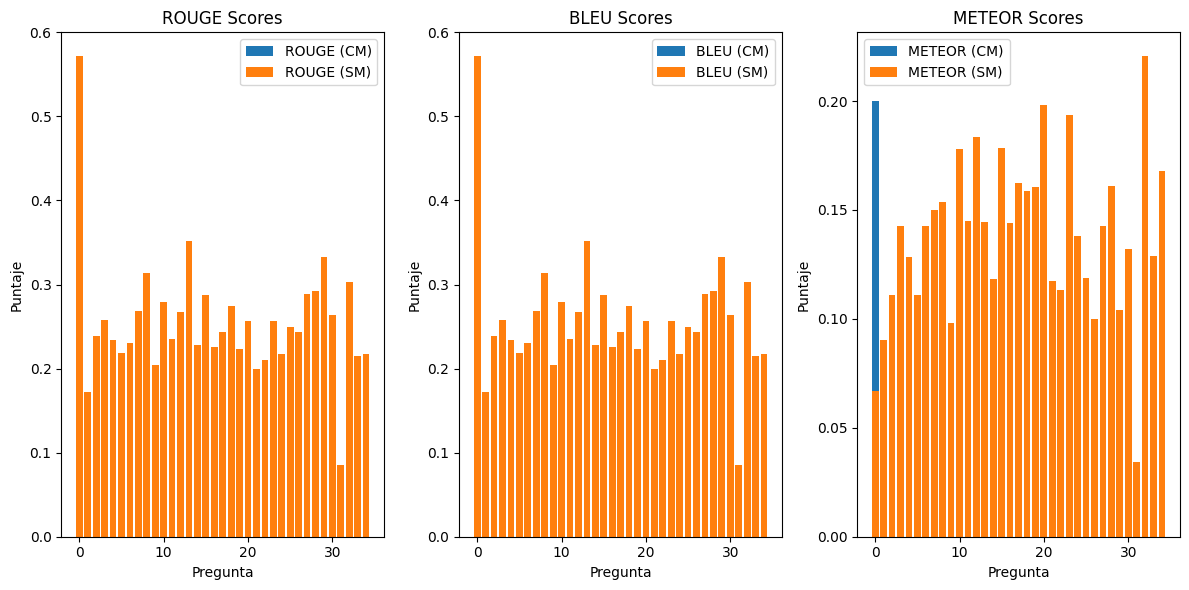

In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np

partes = string.split("Contexto")
partes = [p.strip() for p in partes if p.strip()]

contextos = []
for parte in partes:
    sub_partes = parte.split("P:")
    contexto = sub_partes[0].strip()
    if contexto:
        contextos.append("P:"+contexto)

    for sub_parte in sub_partes[1:]:
        sub_sub_partes = sub_parte.split("E:")
        pregunta = sub_sub_partes[0].strip()
        if pregunta:
            contextos.append("E:"+pregunta)

        for sub_sub_parte in sub_sub_partes[1:]:
            sub_sub_sub_partes = sub_sub_parte.split("SM:")
            respuesta_esperada = sub_sub_sub_partes[0].strip()
            if respuesta_esperada:
                contextos.append("SM:"+respuesta_esperada)

            for sub_sub_sub_parte in sub_sub_sub_partes[1:]:
                sub_sub_sub_sub_partes = sub_sub_sub_parte.split("CM:")
                respuesta_CM = sub_sub_sub_sub_partes[0].strip()
                if respuesta_CM:
                    contextos.append("CM:"+respuesta_CM)

                for sub_sub_sub_sub_parte in sub_sub_sub_sub_partes[1:]:
                    respuesta_SM = sub_sub_sub_sub_parte.strip()
                    if respuesta_SM:
                        contextos.append(respuesta_SM)

# Crear directorio para guardar los resultados
if not os.path.exists("resultados"):
    os.makedirs("resultados")

# Calcular métricas y guardar resultados
rouge_scores_CM = []
rouge_scores_SM = []
bleu_scores_CM = []
bleu_scores_SM = []
meteor_scores_CM = []
meteor_scores_SM = []

for i in range(len(contextos)):
    if contextos[i].startswith("E"):
        respuesta_esperada = contextos[i][2:].strip()
        for j in range(i+1, len(contextos)):
            if contextos[j].startswith("CM"):
                respuesta_CM = contextos[j][3:].strip()
            elif contextos[j].startswith("SM"):
                respuesta_SM = contextos[j][3:].strip()

        rouge_score_CM = ROUGE(respuesta_esperada, respuesta_CM)
        bleu_score_CM = BLEU(respuesta_esperada, respuesta_CM)
        meteor_score_CM = METEOR(respuesta_esperada, respuesta_CM)
        rouge_scores_CM.append(rouge_score_CM)
        bleu_scores_CM.append(bleu_score_CM)
        meteor_scores_CM.append(meteor_score_CM)

        rouge_score_SM = ROUGE(respuesta_esperada, respuesta_SM)
        bleu_score_SM = BLEU(respuesta_esperada, respuesta_SM)
        meteor_score_SM = METEOR(respuesta_esperada, respuesta_SM)
        rouge_scores_SM.append(rouge_score_SM)
        bleu_scores_SM.append(bleu_score_SM)
        meteor_scores_SM.append(meteor_score_SM)

        with open("resultados/resultados.txt", "a") as f:
            f.write(f"Respuesta esperada: {respuesta_esperada}\n")
            f.write(f"Respuesta CM: {respuesta_CM}\n")
            f.write(f"Respuesta SM: {respuesta_SM}\n")
            f.write(f"ROUGE score (CM): {rouge_score_CM:.2f}\n")
            f.write(f"BLEU score (CM): {bleu_score_CM:.2f}\n")
            f.write(f"METEOR score (CM): {meteor_score_CM:.2f}\n")
            f.write(f"ROUGE score (SM): {rouge_score_SM:.2f}\n")
            f.write(f"BLEU score (SM): {bleu_score_SM:.2f}\n")
            f.write(f"METEOR score (SM): {meteor_score_SM:.2f}\n")
            f.write("\n")

# Generar gráficos
x = np.arange(len(rouge_scores_CM))
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(x, rouge_scores_CM, label="ROUGE (CM)")
plt.bar(x, rouge_scores_SM, label="ROUGE (SM)")
plt.title("ROUGE Scores")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(x, bleu_scores_CM, label="BLEU (CM)")
plt.bar(x, bleu_scores_SM, label="BLEU (SM)")
plt.title("BLEU Scores")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(x, meteor_scores_CM, label="METEOR (CM)")
plt.bar(x, meteor_scores_SM, label="METEOR (SM)")
plt.title("METEOR Scores")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.tight_layout()
plt.savefig("resultados/metricas.png")

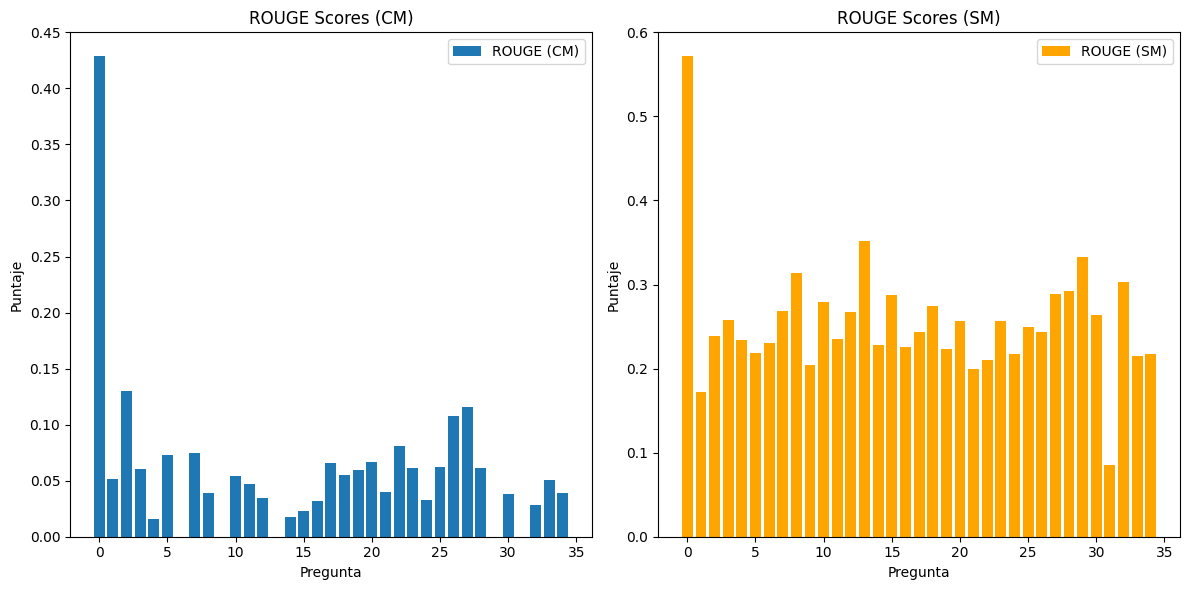

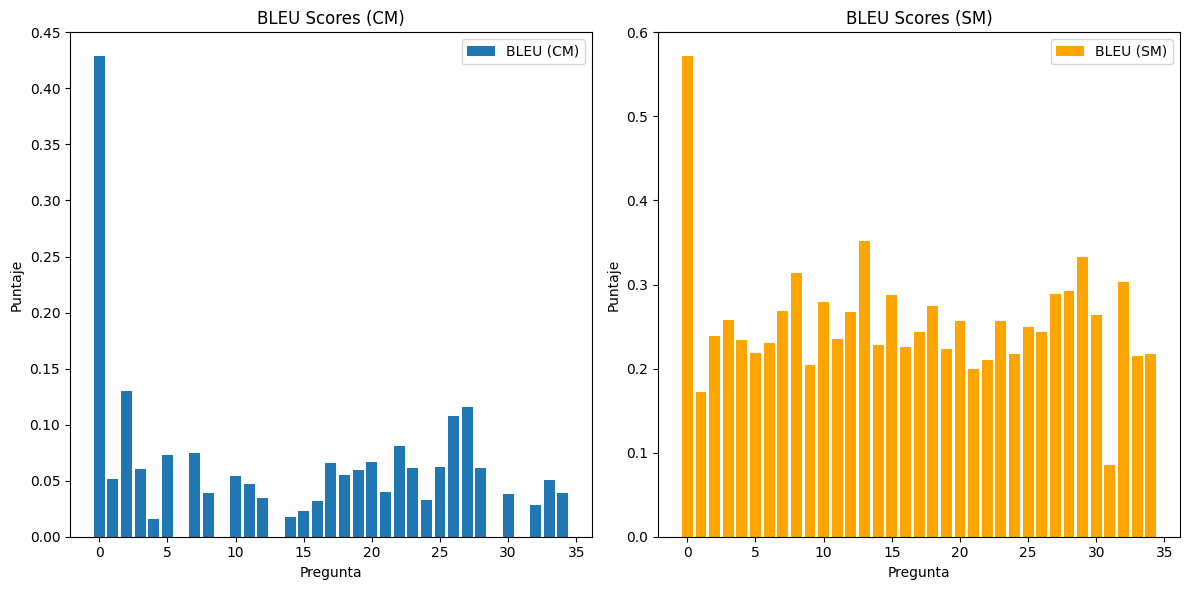

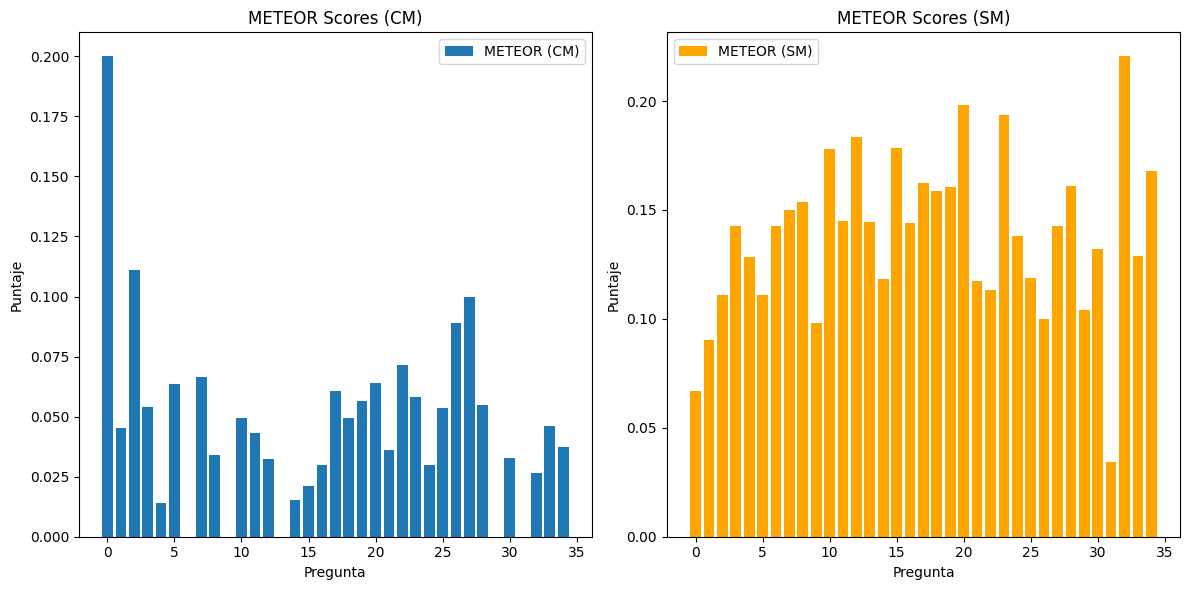

In [49]:
# Calcular métricas y guardar resultados
rouge_scores_CM = []
rouge_scores_SM = []
bleu_scores_CM = []
bleu_scores_SM = []
meteor_scores_CM = []
meteor_scores_SM = []

for i in range(len(contextos)):
    if contextos[i].startswith("E"):
        respuesta_esperada = contextos[i][2:].strip()
        for j in range(i+1, len(contextos)):
            if contextos[j].startswith("CM"):
                respuesta_CM = contextos[j][3:].strip()
            elif contextos[j].startswith("SM"):
                respuesta_SM = contextos[j][3:].strip()

        rouge_score_CM = ROUGE(respuesta_esperada, respuesta_CM)
        bleu_score_CM = BLEU(respuesta_esperada, respuesta_CM)
        meteor_score_CM = METEOR(respuesta_esperada, respuesta_CM)
        rouge_scores_CM.append(rouge_score_CM)
        bleu_scores_CM.append(bleu_score_CM)
        meteor_scores_CM.append(meteor_score_CM)

        rouge_score_SM = ROUGE(respuesta_esperada, respuesta_SM)
        bleu_score_SM = BLEU(respuesta_esperada, respuesta_SM)
        meteor_score_SM = METEOR(respuesta_esperada, respuesta_SM)
        rouge_scores_SM.append(rouge_score_SM)
        bleu_scores_SM.append(bleu_score_SM)
        meteor_scores_SM.append(meteor_score_SM)

        with open("resultados/resultados.txt", "a") as f:
            f.write(f"Respuesta esperada: {respuesta_esperada}\n")
            f.write(f"Respuesta CM: {respuesta_CM}\n")
            f.write(f"Respuesta SM: {respuesta_SM}\n")
            f.write(f"ROUGE score (CM): {rouge_score_CM:.2f}\n")
            f.write(f"BLEU score (CM): {bleu_score_CM:.2f}\n")
            f.write(f"METEOR score (CM): {meteor_score_CM:.2f}\n")
            f.write(f"ROUGE score (SM): {rouge_score_SM:.2f}\n")
            f.write(f"BLEU score (SM): {bleu_score_SM:.2f}\n")
            f.write(f"METEOR score (SM): {meteor_score_SM:.2f}\n")
            f.write("\n")

# Generar gráficos
x = np.arange(len(rouge_scores_CM))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, rouge_scores_CM, label="ROUGE (CM)")
plt.title("ROUGE Scores (CM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, rouge_scores_SM, label="ROUGE (SM)", color ="orange")
plt.title("ROUGE Scores (SM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.tight_layout()
plt.savefig("resultados/rouge_scores.png")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, bleu_scores_CM, label="BLEU (CM)")
plt.title("BLEU Scores (CM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, bleu_scores_SM, label="BLEU (SM)", color ="orange")
plt.title("BLEU Scores (SM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.tight_layout()
plt.savefig("resultados/bleu_scores.png")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, meteor_scores_CM, label="METEOR (CM)")
plt.title("METEOR Scores (CM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, meteor_scores_SM, label="METEOR (SM)", color ="orange")
plt.title("METEOR Scores (SM)")
plt.xlabel("Pregunta")
plt.ylabel("Puntaje")
plt.legend()

plt.tight_layout()
plt.savefig("resultados/meteor_scores.png")